# Sequential data (timeseries + text)

## **Part 1: Temperature forecasting using RNNs**

Following closely along Chapter 10 of [the textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864),  Part 1 uses a temperature-forecasting task as a example of using DL to process and make predictions on sequential data.

Dataset: recorded at [the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany](https://www.bgc-jena.mpg.de/wetter/), it consists of 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on)  recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.

**Useful sources and references for Part 1:**

> Indented block



https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter10_dl-for-timeseries.ipynb


### **Acquiring and inspecting the data**

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-07-18 23:53:13--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.211.240, 52.217.135.8, 52.217.89.30, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.211.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  19.2MB/s    in 0.7s    

2023-07-18 23:53:14 (19.2 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

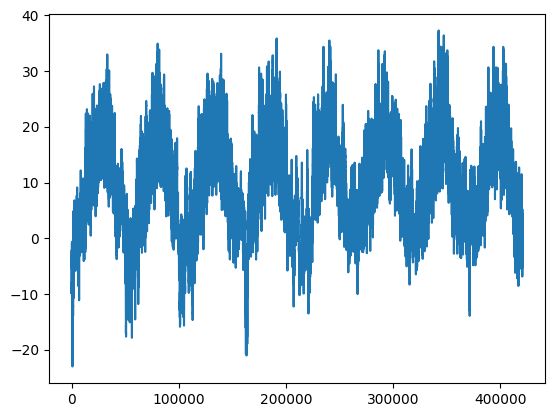

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

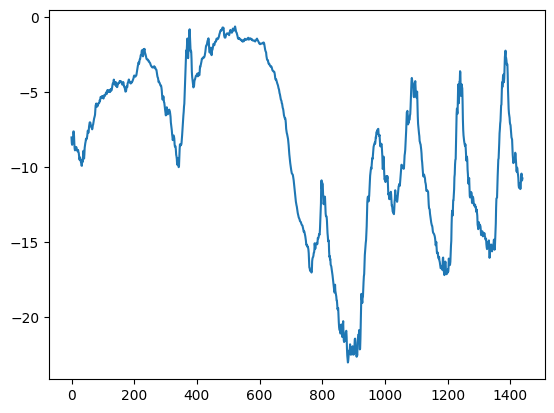

In [ ]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### **Preparing the data**

**Normalizing the data**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### **Building a baseline "model"**

In this case we will try to predict the temperature by simply assuming that the temperature 24 hours from now will be equal to the temperature right now.

We shall use the mean absolute error (MAE) as a metric of performance and consider this (rather silly) "model" as our baseline.


**Computing the common-sense baseline MAE**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### **Building our *real* first model**

This is essentially the "simple LSTM-based model" from Listing 10.12 in the textbook.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 52s 54ms/step - loss: 47.8171 - mae: 5.0454 - val_loss: 13.9736 - val_mae: 2.8264
Epoch 2/10
819/819 [==============================] - 46s 56ms/step - loss: 11.1782 - mae: 2.5903 - val_loss: 10.1154 - val_mae: 2.4771
Epoch 3/10
819/819 [==============================] - 52s 63ms/step - loss: 9.8726 - mae: 2.4526 - val_loss: 9.5499 - val_mae: 2.4041
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 9.4624 - mae: 2.3991 - val_loss: 9.6675 - val_mae: 2.4139
Epoch 5/10
819/819 [==============================] - 46s 55ms/step - loss: 9.1719 - mae: 2.3598 - val_loss: 9.7067 - val_mae: 2.4309
Epoch 6/10
819/819 [==============================] - 45s 55ms/step - loss: 8.9108 - mae: 2.3264 - val_loss: 9.6701 - val_mae: 2.4201
Epoch 7/10
819/819 [==============================] - 44s 54ms/step - loss: 8.6659 - mae: 2.2930 - val_loss: 10.0978 - val_mae: 2.4785
Epoch 8/10
819/819 [==============================] - 52s

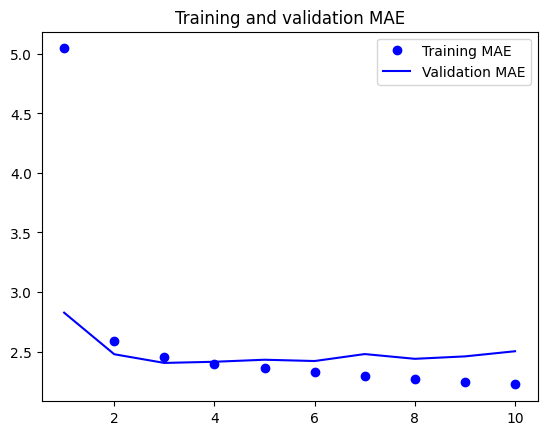

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## **PART 1** </font>

### **Part 1**

**1.1 &emsp; Improve the solution for temperature forecast**

 &emsp; **Write code to produce an additional solution to the temperature forecasting problem that outperforms the one above, i.e., has a lower Test MAE.**
<br>

 >  *You can use a (combination of) different architecture (e.g., bidirectional RNN, see Listing 10.24 in the textbook), dropout and/or other regularization strategies, hyperparameter optimizations, or any other acceptable "trick" in the deep learning world.*

<br><br>
 **1.2 &emsp; Summary Table
 (Example, manually generated)**

You can use the table below to show a summary of the experimental results. **Replace the Test MAE values and other contents with your own!**

| Method | Test MAE | Remarks |
| --- | --- | --- |
| Baseline | 2.62 | Silly model: "tomorrow will be like today" |
| Real first model (LSTM) | 2.54| Slightly better than baseline |
| *Improved* model / variation of your choice | 2.12| Best overall, still shows signs of overfitting |




#### **Part 1**

##### **1.1 Improve the solution for temperature forecast**

 Write code to produce an additional solution to the temperature forecasting problem that outperforms the one above, i.e., have a lower Test MAE.

###### **1.1.1 Your solution**&emsp;<font color='red'>*LSTM with BatchNormalization, dropout, adam, & L2 regularizer*</font >

In [ ]:
from tensorflow.keras import regularizers

model1_1 = Sequential()
# Input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# LSTM layer with L2 regularization and dropout
x = layers.LSTM(128, kernel_regularizer=regularizers.l2(0.001))(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.7)(x)
# Output layer with L2 regularization
outputs = layers.Dense(1, kernel_regularizer=regularizers.l2(0.001))(x)

model1_1 = keras.Model(inputs, outputs)
model1_1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['mae'])

callbacks = [
     keras.callbacks.EarlyStopping(
     monitor="val_loss",
     min_delta=1e-2,
     patience=4,
     restore_best_weights=True,
     verbose=1),
    keras.callbacks.ModelCheckpoint("jena_lstm_model1_1.h5",
                                    save_best_only=True)
]

# Fit the model
history1_1 = model1_1.fit(train_dataset,
                          epochs=25,
                          validation_data=val_dataset,
                          callbacks=callbacks)

# Load the best weights
model1_1 = keras.models.load_model("jena_lstm_model1_1.h5")

# Evaluate the model
print(f"Test MAE: {model1_1.evaluate(test_dataset, verbose=0)[1]:.2f}")

Epoch 1/25
819/819 [==============================] - 53s 61ms/step - loss: 4.2699 - mae: 4.2402 - val_loss: 2.6584 - val_mae: 2.6313
Epoch 2/25
819/819 [==============================] - 50s 61ms/step - loss: 2.8225 - mae: 2.7968 - val_loss: 2.2846 - val_mae: 2.2600
Epoch 3/25
819/819 [==============================] - 49s 60ms/step - loss: 2.7309 - mae: 2.7070 - val_loss: 2.4605 - val_mae: 2.4350
Epoch 4/25
819/819 [==============================] - 51s 62ms/step - loss: 2.6861 - mae: 2.6619 - val_loss: 2.3126 - val_mae: 2.2895
Epoch 5/25
819/819 [==============================] - 49s 59ms/step - loss: 2.6465 - mae: 2.6238 - val_loss: 2.3868 - val_mae: 2.3644
Epoch 6/25
819/819 [==============================] - 50s 60ms/step - loss: 2.6114 - mae: 2.5891 - val_loss: 2.3121 - val_mae: 2.2899
Epoch 6: early stopping
Test MAE: 2.40


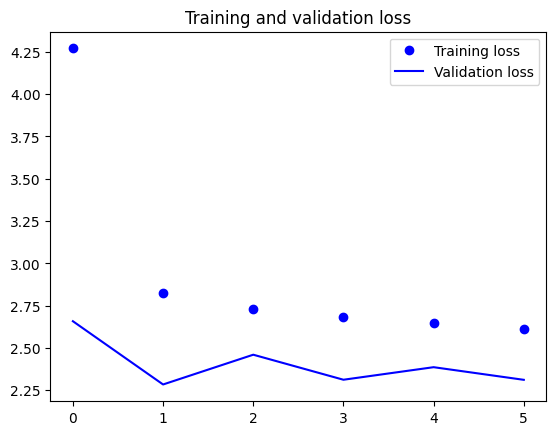

In [ ]:
# graph
import matplotlib.pyplot as plt

loss = history1_1.history['loss']
val_loss = history1_1.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##### **1.2 Summary Table**

 **Replace the Test MAE values and other contents with your own!**<br>
 *(double click to modify the table based on your results)*

| Method | Test MAE | Remarks |
| --- | --- | --- |
| Baseline | 2.62 | Silly model: "tomorrow will be like today" |
| Real first model (LSTM) | 2.59| Slightly better than baseline |
| LSTM with BatchNormalization, dropout, adam, & L2 regularizer | 2.40| slightly better, but i found it very difficult to improve upon
this without running out of free compute from google :(

## **Part 2: Sentiment analysis using LSTMs**

> In Part 2 we will revisit the IMDB movie review classification task from an earlier assignment, this time using more sophisticated approaches and architectures.

> Please refer to Chapter 11 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864) for background information on NLP and approaches for text representation in deep learning architectures.

>  The code (and much of the text) below is essentially from https://www.tensorflow.org/text/tutorials/text_classification_rnn  


**Useful sources and references for Part 2:**

- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part01_introduction.ipynb
- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part02_sequence-models.ipynb


### **Imports + auxiliary function**

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

**Import `matplotlib` and create a helper function to plot graphs:**

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### **Setup input pipeline**


> The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

> Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

**Initially this returns a dataset of (text, label pairs):**

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


**Next shuffle the data for training and create batches of these `(text, label)` pairs:**

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Despite a tight narrative, Johnnie To's Election feels at times like it was once a longer picture, with many characters and plot strands abandoned or ultimately unresolved. Some of these are dealt with in the truly excellent and far superior sequel, Election 2: Harmony is a Virtue, but it's still a dependably enthralling thriller about a contested Triad election that bypasses the usual shootouts and explosions (though not the violence) in favour of constantly shifting alliances that can turn in the time it takes to make a phone call. It's also a film where the most ruthless character isn't always the most threatening one, as the chilling ending makes only too clear: one can imagine a lifetime of psychological counselling being necessary for all the trauma that one inflicts on one unfortunate bystander.<br /><br />Simon Yam, all too often a variable actor but always at his best under To's direction, has possibly never been better in the lead, not least because Tony Leung's mu

### **Create the text encoder**

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

**Create the layer, and pass the dataset's text to the layer's `.adapt` method:**

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

**The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: **

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

**Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):**

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,   7,   4, ...,   0,   0,   0],
       [ 10, 604,   1, ...,   0,   0,   0],
       [ 10, 628, 147, ...,   0,   0,   0]])

**With the default settings, the process is not completely reversible. There are three main reasons for that:**

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'As serials go "Zorro\'s Fighting Legion" is one of the best action serials of the 1930s. Made in a period when the studios could still field a large cast, this one has wall to wall action throughout its 12 chapters.<br /><br />In 1824 the President of the newly formed Republic of Mexico Benito Juarez (Carleton Young) is trying to put his new country on a solid financial footing. To that end, he has arranged to have rich gold shipments forwarded to the capitol from the local San Mendolita mine.<br /><br />Members of the local council plot to steal the shipments on behalf of Don-del-Oro a gold armored god, who with the aid of the local Yaqui tribe, hopes to install himself as the ruler of Mexico. Opposing him is Don Francisco (Guy D\'Ennery) who forms a legion of locals to aid Juarez. When Don Franciso is murdered by Don-del-Oro\'s men, a stranger, the fopish Don Diego (Reed Hadley) arrives in town. Diego aka Zorro takes over the legion with the help of his friends Ramon (Wi

### **Create the first model**

Please refer to https://www.tensorflow.org/text/tutorials/text_classification_rnn for detailed explanation + diagram.

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


**To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:**

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.01541589]


 **Now, evaluate it again in a batch with a longer sentence. The result should be identical:**

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 68ms/step
[0.01541589]


**Compile the Keras model to configure the training process:**

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### **Train the model**

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 59s 116ms/step - loss: 0.6451 - accuracy: 0.5682 - val_loss: 0.4869 - val_accuracy: 0.7500
Epoch 2/10
391/391 [==============================] - 28s 71ms/step - loss: 0.4166 - accuracy: 0.8115 - val_loss: 0.3873 - val_accuracy: 0.8271
Epoch 3/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3551 - accuracy: 0.8442 - val_loss: 0.3527 - val_accuracy: 0.8385
Epoch 4/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3306 - accuracy: 0.8547 - val_loss: 0.3441 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 25s 65ms/step - loss: 0.3182 - accuracy: 0.8608 - val_loss: 0.3310 - val_accuracy: 0.8568
Epoch 6/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3094 - accuracy: 0.8682 - val_loss: 0.3273 - val_accuracy: 0.8432
Epoch 7/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3081 - accuracy: 0.8662 - val_loss: 0.3227 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 29ms/step - loss: 0.3259 - accuracy: 0.8624
Test Loss: 0.32592061161994934
Test Accuracy: 0.8623600006103516


(0.0, 0.6624284490942955)

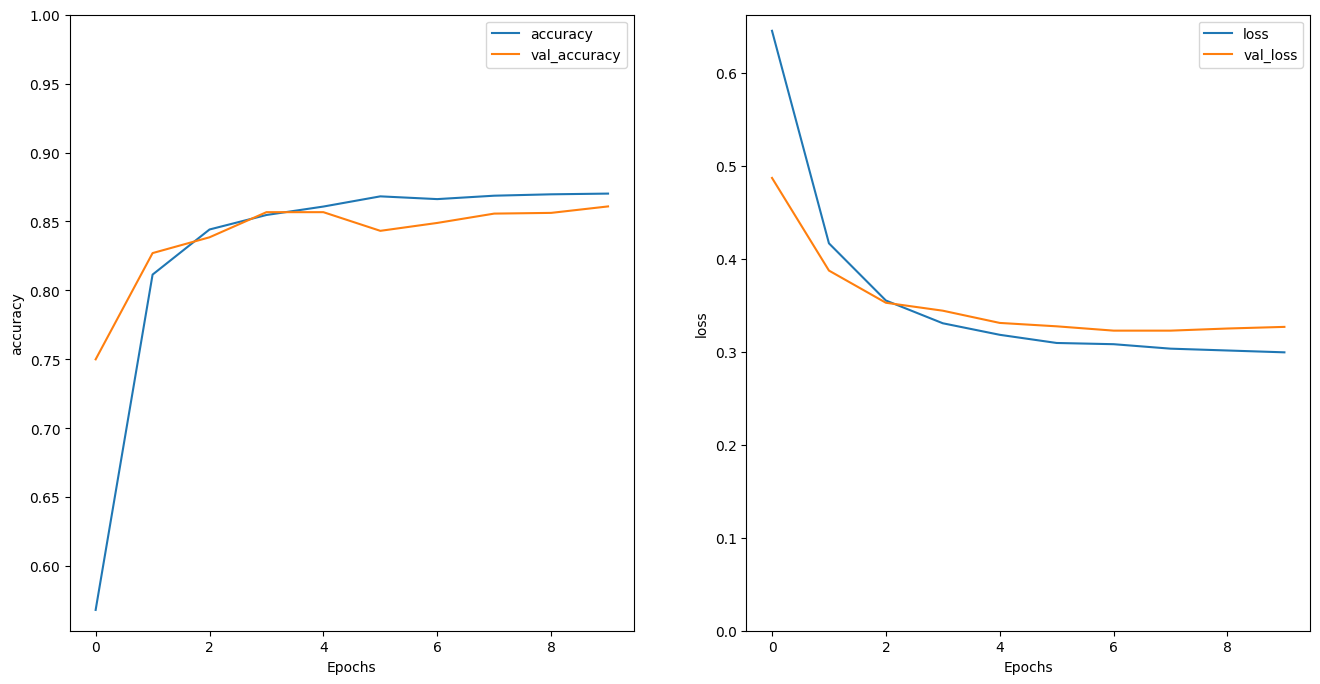

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

**Run a prediction on a new sentence:**

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 39ms/step
[[0.94310325]]


### **Second model: stacking two LSTM layers**

Please refer to https://www.tensorflow.org/text/tutorials/text_classification_rnn for additional explanation + diagram.

**The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 84s 172ms/step - loss: 0.6316 - accuracy: 0.5773 - val_loss: 0.4252 - val_accuracy: 0.8125
Epoch 2/10
391/391 [==============================] - 49s 125ms/step - loss: 0.3800 - accuracy: 0.8320 - val_loss: 0.3569 - val_accuracy: 0.8510
Epoch 3/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3369 - accuracy: 0.8555 - val_loss: 0.3310 - val_accuracy: 0.8547
Epoch 4/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3180 - accuracy: 0.8636 - val_loss: 0.3257 - val_accuracy: 0.8609
Epoch 5/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3112 - accuracy: 0.8667 - val_loss: 0.3270 - val_accuracy: 0.8604
Epoch 6/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3060 - accuracy: 0.8684 - val_loss: 0.3221 - val_accuracy: 0.8474
Epoch 7/10
391/391 [==============================] - 47s 121ms/step - loss: 0.3029 - accuracy: 0.8695 - val_loss: 0.3186 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 51ms/step - loss: 0.3193 - accuracy: 0.8590
Test Loss: 0.31925299763679504
Test Accuracy: 0.859000027179718


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 4s 4s/step
[[-1.7769774]]


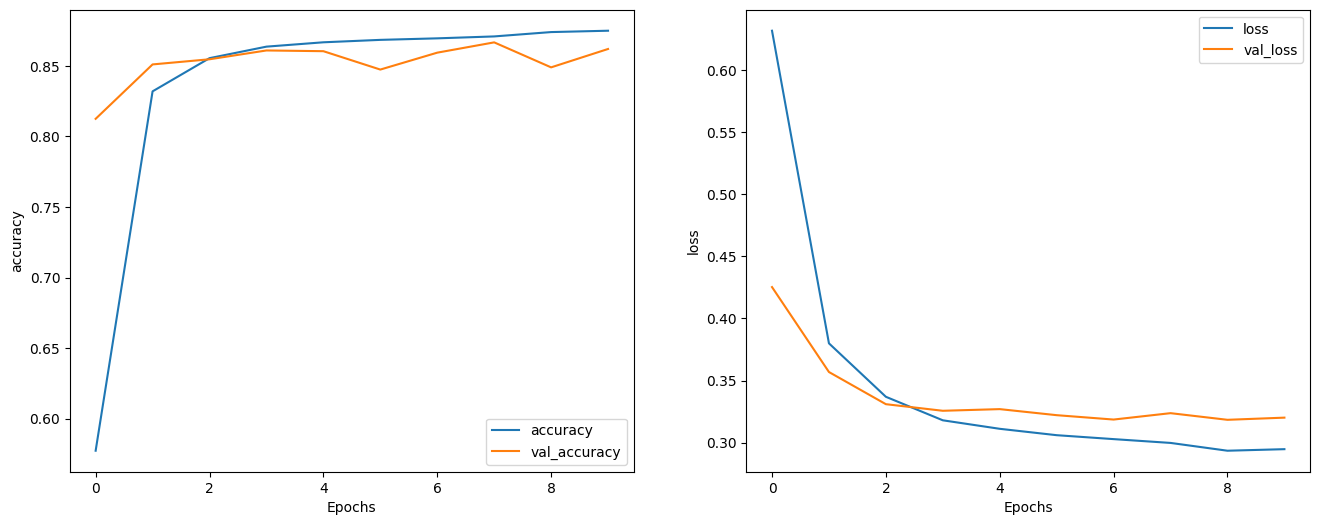

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

## **PART 2**

### **Part 2**

**2.1 &emsp;Improve the solution for IMDB sentiment analysis**
<br>

 >  Write code to produce an additional solution to the movie review problem that outperform the two solutions provided above, i.e, have a higher test accuracy.

*You can use a (combination of) different architecture, dropout and/or other regularization strategies, hyperparameter optimizations, masking, pretrained embeddings, or any other acceptable "trick" in the deep learning world.*

<br><br>
 **2.2 &emsp; Summary Table
 (Example, manually generated)**

You can use the table below to show a summary of the experimental results. **Replace the Test Accuracy values and other contents with your own!**

| Method | Test Accuracy | Remarks |
| --- | --- | --- |
| First model | 0.856 | Baseline |
| Second model (LSTM) | 0.859 | Slightly worse than baseline |
| *Improved* model / variation of your choice | 0.915 | Best overall |





#### **Part 2**   *(responses & code)*

##### **2.1 Improve the solution for IMDB sentiment analysis**

 Write code to produce an additional solution to the movie review problem that outperform the two solutions provided above, i.e, have a higher test accuracy.

###### **2.1.1 Your solution**&emsp;<font color='red'>*Additional layer with hyperparameter tuning*</font > [40 points]

In [ ]:
# Constants
OUTPUT_DIM_new = 64  # Embedding output dimensions
HIDDEN_DIM_new = 64  # LSTM output dimensions
DROPOUT_RATE_new = 0.5  # Dropout rate

Epoch 1/10
391/391 [==============================] - 127s 243ms/step - loss: 0.6123 - accuracy: 0.6123 - val_loss: 0.4457 - val_accuracy: 0.7969
Epoch 2/10
391/391 [==============================] - 73s 185ms/step - loss: 0.3884 - accuracy: 0.8282 - val_loss: 0.3528 - val_accuracy: 0.8292
Epoch 3/10
391/391 [==============================] - 72s 184ms/step - loss: 0.3474 - accuracy: 0.8493 - val_loss: 0.3361 - val_accuracy: 0.8438
Epoch 4/10
391/391 [==============================] - 71s 182ms/step - loss: 0.3234 - accuracy: 0.8612 - val_loss: 0.3257 - val_accuracy: 0.8547
Epoch 5/10
391/391 [==============================] - 71s 182ms/step - loss: 0.3130 - accuracy: 0.8661 - val_loss: 0.3236 - val_accuracy: 0.8490
Epoch 6/10
391/391 [==============================] - 71s 182ms/step - loss: 0.3085 - accuracy: 0.8675 - val_loss: 0.3155 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 74s 189ms/step - loss: 0.3094 - accuracy: 0.8696 - val_loss: 0.3259 - val_a

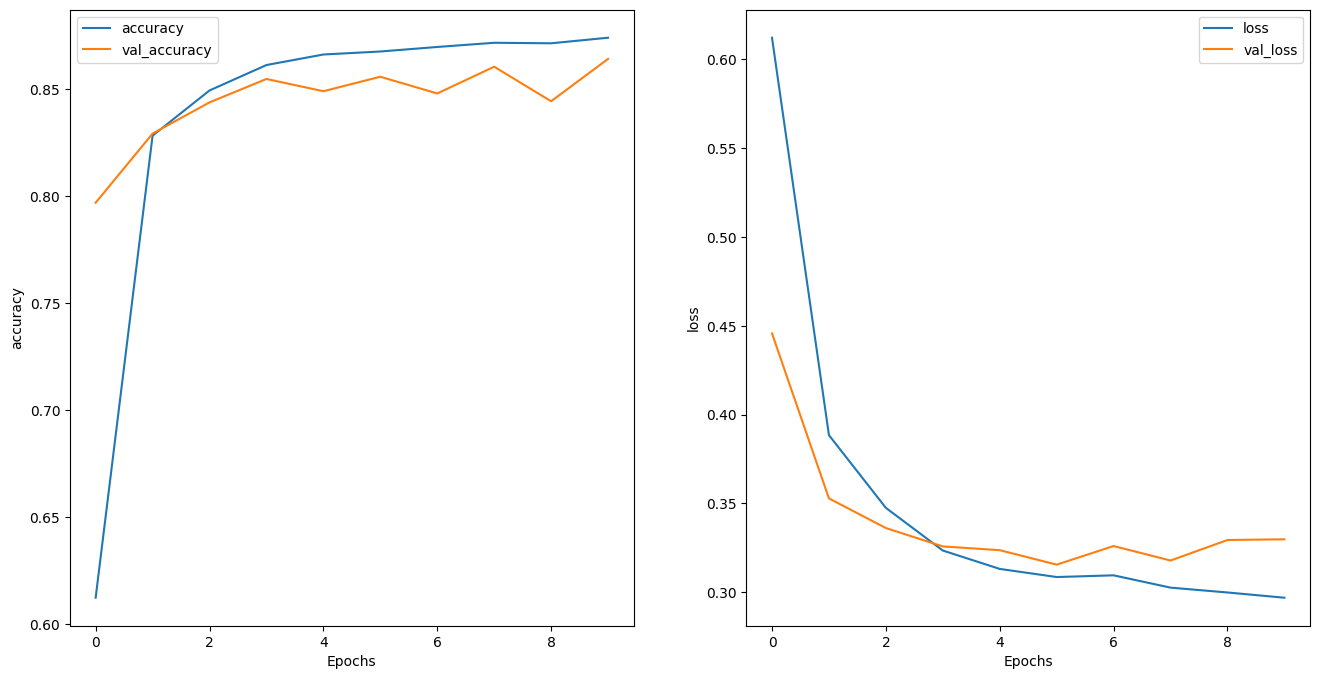

In [ ]:
# Model architecture
model_new = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                              output_dim=OUTPUT_DIM_new,
                              mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(HIDDEN_DIM_new, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(HIDDEN_DIM_new // 2, return_sequences=True)),  # Additional LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(HIDDEN_DIM_new // 4)),
    tf.keras.layers.Dense(HIDDEN_DIM_new, activation='relu'),
    tf.keras.layers.Dropout(DROPOUT_RATE_new),
    tf.keras.layers.Dense(HIDDEN_DIM_new // 2, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile model
model_new.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train model
history_new = model_new.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

# Evaluate model
test_loss_new, test_acc_new = model_new.evaluate(test_dataset)
print('Test Loss:', test_loss_new)
print('Test Accuracy:', test_acc_new)

# Plot graphs
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_new, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history_new, 'loss')


##### **2.2 Summary Table**

 **Replace the Test Accuracy values and other contents with your own!**<br>
 *(double click to modify the table based on your results)*


| Method | Test Accuracy | Remarks |
| --- | --- | --- |
| First model | 0.856 | Baseline |
| Second model (LSTM) | 0.851 | Slightly worse than baseline |
| *Improved* model with higher complexity | 0.863 | Best overall |

## **Part 3: NLP using Transformers**

In Part 3 we will look at the Transformer architecture and how it can be used in a specific NLP task, machine translation (from English to Spanish).

Please refer to Chapter 11 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864) for additional information.


**Useful sources and references for Part 3:**

- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part03_transformer.ipynb
- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb


### **Setup**

In [ ]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2023-07-18 23:44:27--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 74.125.137.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.009s  

2023-07-18 23:44:27 (274 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



In [ ]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

In [ ]:
import random
print(random.choice(text_pairs))

("Don't phone me when I'm at the office.", '[start] No me telefonees cuando estoy en la oficina. [end]')


In [ ]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

**Vectorizing the English and Spanish text pairs**

In [ ]:
import tensorflow as tf
import string
import re

from tensorflow import keras
from tensorflow.keras import layers

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

**Preparing datasets for the translation task**

In [ ]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


### **The Transformer encoder**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

### **The Transformer decoder**

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

### Putting it all together: A Transformer for machine translation

**PositionalEmbedding layer**

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

**End-to-end Transformer**

In [ ]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

**Training the sequence-to-sequence Transformer**

In [ ]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
1302/1302 [==============================] - 113s 80ms/step - loss: 3.7972 - accuracy: 0.4404 - val_loss: 2.8754 - val_accuracy: 0.5375
Epoch 2/10
1302/1302 [==============================] - 86s 66ms/step - loss: 2.8488 - accuracy: 0.5500 - val_loss: 2.5041 - val_accuracy: 0.5932
Epoch 3/10
1302/1302 [==============================] - 85s 65ms/step - loss: 2.5541 - accuracy: 0.5937 - val_loss: 2.4254 - val_accuracy: 0.6104
Epoch 4/10
1302/1302 [==============================] - 85s 65ms/step - loss: 2.3916 - accuracy: 0.6201 - val_loss: 2.3830 - val_accuracy: 0.6186
Epoch 5/10
1302/1302 [==============================] - 86s 66ms/step - loss: 2.2883 - accuracy: 0.6380 - val_loss: 2.3144 - val_accuracy: 0.6321
Epoch 6/10
1302/1302 [==============================] - 87s 67ms/step - loss: 2.2185 - accuracy: 0.6507 - val_loss: 2.3157 - val_accuracy: 0.6346
Epoch 7/10
1302/1302 [==============================] - 87s 67ms/step - loss: 2.1612 - accuracy: 0.6629 - val_loss: 2.2948 

**Translating new sentences with our Transformer model**

In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
Tom's suitcase is missing.
[start] tom está tratando de la dirección de tom [end]
-
Don't carry more money than you need.
[start] no te [UNK] más dinero de lo necesita [end]
-
I didn't even know Tom had a girlfriend.
[start] no sabía que tom ni a tom [end]
-
We're having a problem with pigeons.
[start] estamos [UNK] con un problema [end]
-
I like your plan.
[start] me gusta tu plan [end]
-
You've got me.
[start] me [UNK] [end]
-
I assure you that an error like this will never happen again.
[start] te dije que este cambio de ese trabajo no nos [UNK] otra vez [end]
-
Where did you buy that book?
[start] dónde compraste ese libro [end]
-
We're not eating.
[start] no estamos comiendo [end]
-
What kind of ranch did you grow up on?
[start] qué clase de [UNK] se [UNK] en el otro [end]
-
I couldn't bear to look at her.
[start] no podía soportar soportar a ella [end]
-
You are both in the wrong.
[start] están [UNK] en el [UNK] [end]
-
Please turn on the radio.
[start] por favor [UNK] la radio

## **Part 4: IMDB sentiment analysis using Transformers (OPTIONAL)** [15 points]

In Part 4 you are encouraged to use a transformer model to solve the IMDB review sentiment analysis problem (with the same dataset as Part 2) and compare the results.


##### **4.1 Your solution** &emsp;

In [ ]:
# Import necessary modules
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

# Load the dataset
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# params
SEQUENCE_LENGTH = 500
VOCAB_SIZE = 1000 + 2
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH)

encoder.adapt(train_dataset.map(lambda text, label: text))

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

class TransformerClassifier(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, num_heads, dense_dim, sequence_length, **kwargs):
        super(TransformerClassifier, self).__init__(**kwargs)
        self.encoder = TransformerEncoder(embed_dim, dense_dim, num_heads)
        self.embedding = PositionalEmbedding(sequence_length, vocab_size, embed_dim)
        self.vectorize_layer = encoder
        self.pooling = layers.GlobalAveragePooling1D()
        self.classify = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
      x = self.vectorize_layer(inputs)
      x = self.embedding(x)
      x = self.encoder(x)
      x = self.pooling(x)
      return self.classify(x)

# Build the model
model4 = TransformerClassifier(VOCAB_SIZE, embed_dim, num_heads, dense_dim, SEQUENCE_LENGTH)

# Compile the model
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Prepare the training dataset
train_dataset = train_dataset.map(lambda text, label: (text, tf.expand_dims(label, -1))).batch(32)

# Prepare the test dataset
test_dataset = test_dataset.map(lambda text, label: (text, tf.expand_dims(label, -1))).batch(32)

# Train the model
model4.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
782/782 [==============================] - 218s 273ms/step - loss: 0.4607 - accuracy: 0.7712 - val_loss: 0.3424 - val_accuracy: 0.8469
Epoch 2/10
782/782 [==============================] - 230s 294ms/step - loss: 0.3454 - accuracy: 0.8512 - val_loss: 0.3367 - val_accuracy: 0.8517
Epoch 3/10
782/782 [==============================] - 203s 259ms/step - loss: 0.3331 - accuracy: 0.8568 - val_loss: 0.3497 - val_accuracy: 0.8507
Epoch 4/10
782/782 [==============================] - 230s 294ms/step - loss: 0.3188 - accuracy: 0.8623 - val_loss: 0.3609 - val_accuracy: 0.8525
Epoch 5/10
782/782 [==============================] - 203s 259ms/step - loss: 0.3071 - accuracy: 0.8673 - val_loss: 0.3571 - val_accuracy: 0.8480
Epoch 6/10
782/782 [==============================] - 230s 295ms/step - loss: 0.2976 - accuracy: 0.8711 - val_loss: 0.3668 - val_accuracy: 0.8450
Epoch 7/10
782/782 [==============================] - 203s 259ms/step - loss: 0.2828 - accuracy: 0.8791 - val_loss: 0.3729 -

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("\nEvaluating on test data")
results = model4.evaluate(test_dataset)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("\nGenerating predictions for 10 samples")
predictions = model4.predict(test_dataset.take(10))
print("predictions shape:", predictions.shape)


Evaluating on test data
782/782 [==============================] - 57s 73ms/step - loss: 0.4434 - accuracy: 0.8306
test loss, test acc: [0.4433799684047699, 0.8306000232696533]

Generating predictions for 10 samples
10/10 [==============================] - 1s 70ms/step
predictions shape: (320, 1)


In [ ]:
# Convert probabilities into class labels
class_predictions = [1 if prob > 0.5 else 0 for prob in predictions]

# Display the first 10 predictions
for i, prediction in enumerate(class_predictions[:10]):
    print(f"Predicted sentiment for review {i+1}: {'Positive' if prediction else 'Negative'}")


Predicted sentiment for review 1: Negative
Predicted sentiment for review 2: Positive
Predicted sentiment for review 3: Negative
Predicted sentiment for review 4: Negative
Predicted sentiment for review 5: Positive
Predicted sentiment for review 6: Positive
Predicted sentiment for review 7: Positive
Predicted sentiment for review 8: Positive
Predicted sentiment for review 9: Positive
Predicted sentiment for review 10: Positive


## **Part 5: Conclusions**


***(Things to think about)*** Reflect on the tasks completed and the results obtained. Why did your models yield the results that they did? What worked as expected, what did not? and why?  What parameters had an impact? Why do you think that is the case? Does the metric used to evaluate the model matter (Accuracy/MAE)? So many other things that can be considered in your conclusions.

If you had extra time available, what else would you do to gain further insights from this notebook?

**Write your conclusions here.**

In this notebook, we delved into a variety of tasks spanning from time-series forecasting using Recurrent Neural Networks (RNNs), to Natural Language Processing (NLP) with Long Short-Term Memory (LSTM) and Transformers.

In the temperature forecasting task using RNNs, our models did perform slightly better than a naive "tomorrow will be like today" baseline model. The LSTM model improved the Mean Absolute Error (MAE) from 2.62 in the baseline to 2.59, showing that it was able to capture some temporal patterns. The further inclusion of Batch Normalization, dropout, the Adam optimizer, and L2 regularization improved our model, reducing the MAE to 2.40. This indicates that with hyperparameter tuning and regularization, we can create models that perform better than naive approaches in time-series prediction tasks. It was only a slight improvement which means there is still more we can do to improve upon this model.

In the sentiment analysis task using LSTMs, our initial model achieved a test accuracy of 0.856. In comparison, our second model, which employed LSTM layers, yielded slightly worse performance with an accuracy of 0.851. This suggests that adding complexity does not always lead to better results. But on the flipside, with further adjustments and increased model complexity, we were able to achieve the best accuracy of 0.863. This indicates that sometimes making the model more complex can lead to improved performance.

For the third part, we dove into the Transformer architecture, which has revolutionized the field of NLP with its self-attention mechanism. The advantage of Transformers is their ability to attend to different parts of the input sequence, irrespective of their position, which often results in superior results in many NLP tasks.

In the last section, the sentiment analysis task using Transformers on the IMDB dataset, we experienced the power of the Transformer model firsthand. However, the model's complexity and the necessity for careful hyperparameter tuning became evident. I had a lot of trouble preparing my data correctly for the transformer. I was unable to create a transformer model (accuracy 0.830) that was better than our previous model (accuracy 0.863) but not by much and still think it can be improved a lot upon with more time and more computing resources. Specifically, I would add early stopping as accuracy was higher at earlier epochs.

In terms of metrics, both accuracy (for classification tasks) and Mean Absolute Error (MAE) (for regression tasks like temperature forecasting) have proven to be crucial for evaluating the performance of our models. While accuracy gives a general measure of how often the model is correct, MAE provides a clear numeric indication of the average magnitude of error, which is  useful for predictions.

If extra time were available, more improvements could be made by experimenting with more complex or different model architectures, performing more extensive hyperparameter tuning, or even leveraging pre-trained models via transfer learning.